# <font color='367588'>Forecasting Ethereum Prices Using LSTM</font>

### <font color='FFA500'>Introduction</font>

**Ethereum (ETH)** is one of the world’s leading cryptocurrencies and blockchain platforms, known for its smart contract functionality and growing ecosystem. Like other digital assets, Ethereum's price exhibits **high volatility**, influenced by market sentiment, macroeconomic events, and technology adoption. Accurate forecasting of its price movements can be valuable for traders, analysts, and researchers in the blockchain domain.

### <font color='FFA500'>Objective</font>

This notebook aims to perform **univariate time series forecasting**  by implementing  **Long Short-Term Memory (LSTM)** . 
LSTM is a type of recurrent neural network (RNN) capable of learning temporal dependencies in sequential data, making it well-suited for tasks like **cryptocurrency price prediction**.

Using historical Ethereum price data from **2017 to 2024**, we will:
- Prepare and normalize the dataset
- Create time-based sequences for training
- Build and train an LSTM model
- Forecast future prices
- Evaluate model performance with common error metrics




# <font color='FFA500'>Importing requiremenets</font>

In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential

# <font color='FFA500'>Loading and Analyzing the Dataset</font>


In [5]:

data = pd.read_csv("I:/CQAI/TSA/TSD/TSD/archive/ETH-USD (2017-2024).csv",parse_dates=["Date"],index_col=["Date"],usecols=["Date","Close"])
data



,Close
Date,
2017-11-10,299.252991
2017-11-11,314.681000
2017-11-12,307.907990
2017-11-13,316.716003
2017-11-14,337.631012
...,...
2024-01-17,2528.369385
2024-01-18,2467.018799
2024-01-19,2489.498535


In [6]:
data.isnull().sum()

Close    1
dtype: int64

In [12]:
data.shape

(2263, 1)

In [7]:
data=data.dropna()

In [8]:
data.describe()

,Close
count,2263.000000
mean,1248.811361
std,1118.664405
min,84.308296
25%,231.901916
50%,1039.099976
75%,1871.952942
max,4812.087402


# <font color='FFA500'>Visualizing the data</font>

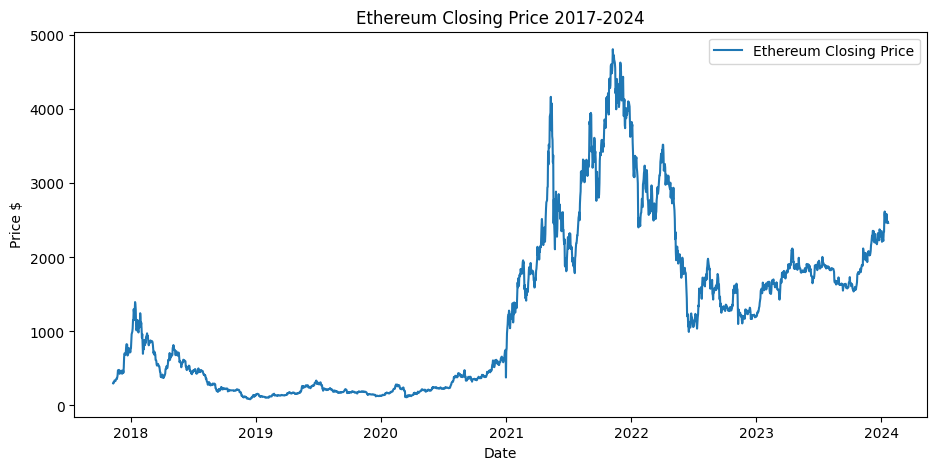

In [9]:
# Visualizing the Ethereum closing price
def plot(df,col):
    plt.figure(figsize=(11, 5))
    plt.plot(df[col], label='Ethereum Closing Price')
    plt.title('Ethereum Closing Price 2017-2024')

    plt.xlabel('Date')
    plt.ylabel('Price $')
    plt.legend()
    plt.show()
plot(data,"Close")

# <font color='FFA500'>Data Preprocessing</font>
Before applying LSTM model the data needs to be normalized first. This way the model performance and hence forecasting is better


In [10]:
# we use min max scaler to bring value within range 0 to 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

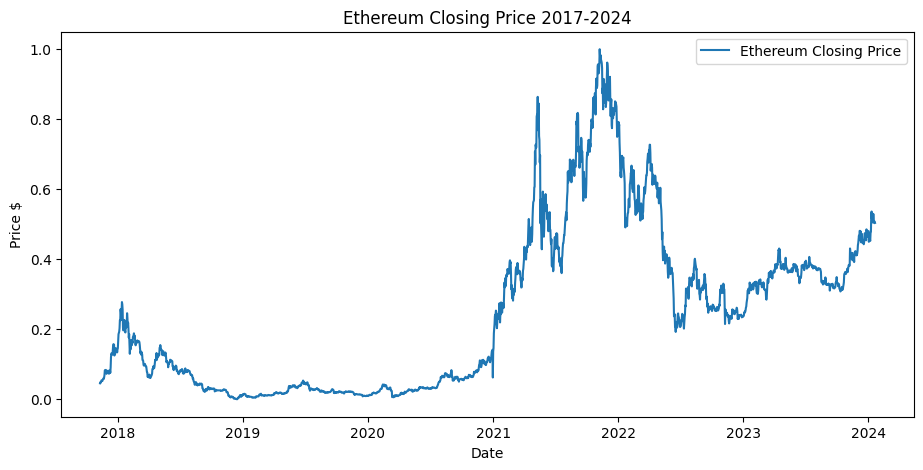

In [11]:

scaled_df = pd.DataFrame(scaled_data, index=data.index, columns=['Scaled_Close'])
scaled_df
plot(scaled_df,"Scaled_Close")

# <font color='FFA500'>Sequence Creation</font>

we create sequences of **30 consecutive days** to serve as input, 

Each sequence helps the model learn how the past 30 days influence the next day’s price.

---

### <font color='FFA500'>Why Do We Need Sequence Creation?</font>

LSTM (Long Short-Term Memory) networks are designed to learn from **ordered sequences of data**. In time series forecasting, this means:

- The model learns **temporal dependencies**—how past prices influence future prices.
- It can capture patterns like **trends**, **momentum**, and **seasonal shifts** over time.
- Without sequences, the model would treat each price point independently, ignoring order, which is critical in time-based data.

---

### <font color='FFA500'>How It Works</font>

For a window size of 30:
- The model takes prices from day 1 to day 30 as **input**
- It tries to predict the price on **day 31**

This process slides forward one step at a time:
- Days 2–31 → predict day 32  
- Days 3–32 → predict day 33  
...and so on, until the end of the dataset.

This approach transforms a 1D time series into a 2D array of input-output pairs suitable for training an LSTM.





In [13]:

def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        labels.append(data[i + sequence_length, 0])
    return np.array(sequences), np.array(labels)

sequence_length = 30


# <font color='FFA500'>Train-Test Split</font>

The dataset is divided into **training** and **testing** sets.  
Specifically, **80% of the data** is used to train the model, while the remaining **20%** is reserved for testing.  

This ensures that the model is evaluated on **unseen data**, allowing us to assess its ability to generalize to future price movements.


In [14]:
len(scaled_data)

2263

In [16]:

train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]



In [18]:

X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

In [19]:
print(train_data.shape,test_data.shape)

(1810, 1) (453, 1)


## <font color='FFA500'>Building the LSTM Model</font>
Here,we construct an LSTM model with two LSTM layers and dropout to prevent overfitting.

**LSTM Layers :** These layers capture long-term dependencies in the time series data.

**Dropout:** Regularization to reduce the chance of overfitting.

**Dense Layers :** Fully connected layers to output a single price prediction.

In [111]:

model = Sequential()

# First LSTM layer with Dropout regularization
model.add(Input(shape=(X_train.shape[1], 1)))  
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

#Secnd LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Dense layers for output
model.add(Dense(units=25))
model.add(Dense(units=1))  #Final output layer


# <font color='FFA500'> Compiling and Fitting the Model</font>
The model is compiled using the Adam optimizer and mean squared error as the loss function

The model is trained over 60 epochs using a batch size of 90. The training and validation loss is tracked to ensure the model is learning effectively.


### <font color='FFA500'> Why Use the Adam Optimizer?</font>

The **Adam (Adaptive Moment Estimation)** optimizer is effective for training deep learning models as it combines the benefits of **AdaGrad** and **RMSProp**.

- ✅ Adapts learning rates for faster convergence  
- ✅ Handles noisy, volatile data well (like cryptocurrency prices)  
- ✅ Performs reliably with minimal parameter tuning

Adam enables the LSTM model to efficiently learn complex time-based patterns in Ethe


In [123]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


model.fit(X_train, y_train, epochs=70, batch_size=90, validation_data=(X_test, y_test))

Epoch 1/70


20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - loss: 0.0010 - val_loss: 1.0577e-04
Epoch 2/70
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 7.9680e-04 - val_loss: 1.0643e-04
Epoch 3/70
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 8.6093e-04 - val_loss: 1.7164e-04
Epoch 4/70
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 8.4911e-04 - val_loss: 1.0020e-04
Epoch 5/70
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 7.8057e-04 - val_loss: 1.1201e-04
Epoch 6/70
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 8.3998e-04 - val_loss: 1.0607e-04
Epoch 7/70
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 7.3772e-04 - val_loss: 2.0135e-04
Epoch 8/70
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 7.5746e-04 - val_loss: 1.5173e-04
Epoch 9/70
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 8.9725e-04 - val_loss: 1.0790e-04
Epoch 10/70
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 8.2396e-04 - val_loss: 1.9180e-04
Epoch 11/70
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 7.6640e-04 - val_loss: 

In [124]:
# Evaluate on test set
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss * 100}%')

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 8.4556e-05
Test Loss: 0.009837713878368959%


# <font color='FFA500'> Lets do Predictions on Test data now</font>

In [125]:
predictions = model.predict(X_test)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step





**Inverse Scaling :** I convert the scaled predictions and actual test data back to their original scale for interpretation.

**MSE Calculation :** The model’s performance is measured based on how close its predictions are to the actual prices.

In [126]:
# Inverse scaling predictions back to the original scale
predictions = scaler.inverse_transform(predictions)

# Inverse scaling the actual test values
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))



# <font color='FFA500'> Model Evaluation </font>

In [127]:
from sklearn.metrics import mean_squared_error as MSE
mse = mean_squared_error(y_test_scaled, predictions)
print(f"Mean Squared Error: {mse}")

rmse = np.sqrt(MSE(y_test_scaled, predictions))
print("Mean Value of Test Dataset:", y_test_scaled.mean())
print("RMSE : % f" %(rmse))

Mean Squared Error: 2198.9147613578743
Mean Value of Test Dataset: 1774.213625673759
RMSE :  46.892587


# <font color='FFA500'> Visualization- Actual vs Predicted </font>


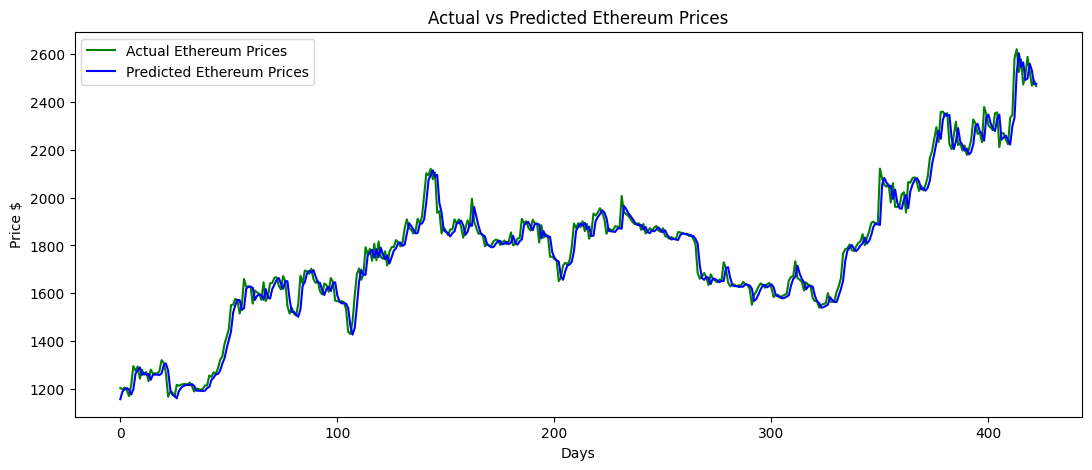

In [128]:


plt.figure(figsize=(13, 5))


plt.plot(y_test_scaled, label='Actual Ethereum Prices', color='green')

# predicted prices
plt.plot(predictions, label='Predicted Ethereum Prices', color='blue')

# Plotting
plt.title('Actual vs Predicted Ethereum Prices')
plt.xlabel('Days')
plt.ylabel('Price $')
plt.legend()


plt.show()


# <font color='FFA500'> Forecasting the Future</font>

In [129]:

future_days = 50

# Get the last 60 days of data for starting the predictions
last_50_days = data['Close'][-sequence_length:].values.reshape(-1, 1)
last_50_days_scaled = scaler.transform(last_50_days)

future_predictions = []

for i in range(future_days):
    # Create a new sequence from the last 60 days
    X_predict = []
    X_predict.append(last_50_days_scaled)
    X_predict = np.array(X_predict)
    X_predict = np.reshape(X_predict, (X_predict.shape[0], X_predict.shape[1], 1))
    
    # Predict the price for the next day
    predicted_price = model.predict(X_predict)
    predicted_price_unscaled = scaler.inverse_transform(predicted_price)
    
    # Store the predicted price
    future_predictions.append(predicted_price_unscaled[0, 0])
    
    # Update the sequence to include the predicted price
    new_scaled_data = np.append(last_50_days_scaled[1:], predicted_price, axis=0)
    last_50_days_scaled = new_scaled_data.reshape(-1, 1)


future_dates = pd.date_range(start=data.index[-1], periods=future_days+1, freq='D')[1:]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━

## <font color='FFA500'> Visualizing Future Predictions</font>


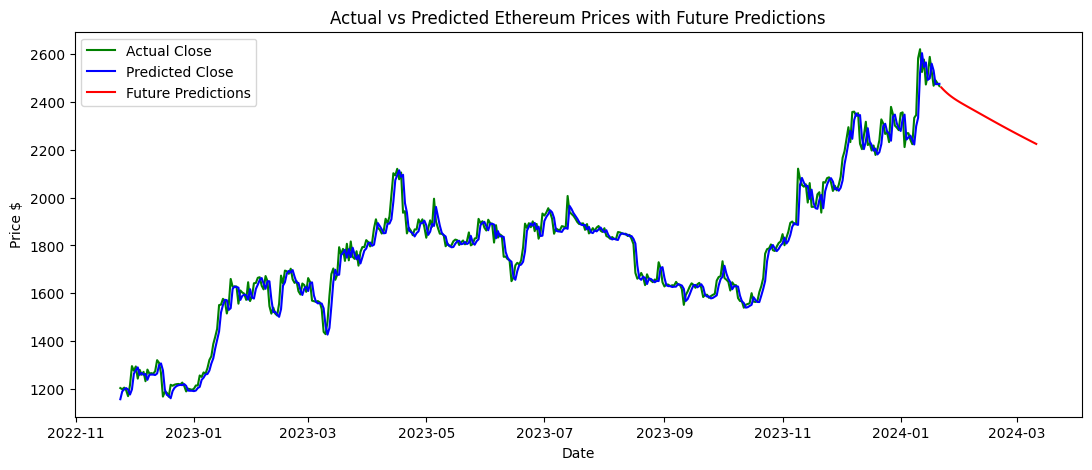

In [130]:
# Plotting future predictions alongside actual prices

plt.figure(figsize=(13, 5))

plt.plot(data.index[-len(y_test_scaled):], y_test_scaled, label='Actual Close', color='green')

# predictions price
plt.plot(data.index[-len(y_test_scaled):], predictions, label='Predicted Close', color='blue')

# Future Predictions (Next 60 Days)
plt.plot(future_dates, future_predictions, label='Future Predictions', color='red')

# Plotting
plt.title('Actual vs Predicted Ethereum Prices with Future Predictions')
plt.xlabel('Date')
plt.ylabel('Price $')
plt.legend()


plt.show()


In [134]:
print("future Predictions:\n",future_predictions[:9])


future Predictions:
 [2459.8093, 2451.182, 2443.2812, 2435.9224, 2429.1003, 2422.7747, 2416.8745, 2411.3296, 2406.0703]


In [ ]:

#Actual future prices 
'''
2310.826416
2240.686035
2233.561768
2217.710205
2267.199707
2267.885986
2257.208740
2317.064209

'''
